MCMC For dirichlet mixture models

In [ ]:
!pip install --upgrade cmdstanpy
!pip install git+https://github.com/OriolAbril/arviz.git@ci

from cmdstanpy import install_cmdstan
install_cmdstan()

  Cloning https://github.com/OriolAbril/arviz.git (to revision ci) to /tmp/pip-req-build-ak501m7v
  Running command git clone --filter=blob:none --quiet https://github.com/OriolAbril/arviz.git /tmp/pip-req-build-ak501m7v
  Running command git checkout -b ci --track origin/ci
  Switched to a new branch 'ci'
  Branch 'ci' set up to track remote branch 'ci' from 'origin'.
  Resolved https://github.com/OriolAbril/arviz.git to commit 7c20182c25b0b5e9af8242d1ee4d1185ae82b70a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


CmdStan install directory: /root/.cmdstan
CmdStan version 2.34.1 already installed
Test model compilation


True

In [ ]:
# Required modules
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os

# Required functions
from cmdstanpy import CmdStanModel
from scipy.special import softmax
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Create ./stan folder if does not exists
if not os.path.exists("./stan"):
    os.mkdir("./stan")

# Create ./output folder if does not exists
if not os.path.exists("./output"):
    os.mkdir("./output")

In [ ]:
import scipy
from scipy import stats
from scipy.stats import invwishart
from scipy.stats import beta
from jax.scipy.special import betaln
from scipy.special import digamma
from jax.scipy.special import gammaln
from numpy.random import multivariate_normal as mvn
from matplotlib import cm
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
from numpy.random import multivariate_normal as mvn
from numpy.random import gamma
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
!pip install mycolorpy
from mycolorpy import colorlist as mcp

*DATA GENERATION*

0.9999999999999999


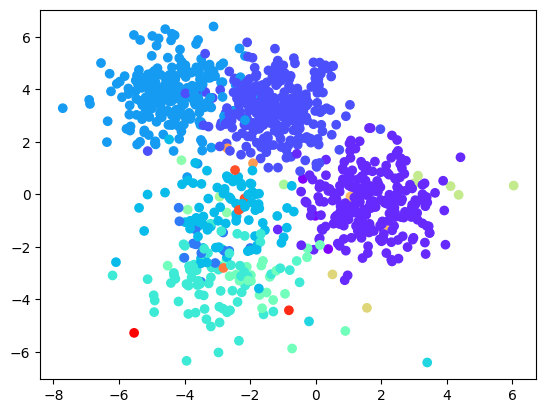

Final number of clusters:  20


In [ ]:
seed=2022
np.random.seed(seed)

# Instantiate the first topic
alpha = 5.0
n = 1000
d = 2
a = 3.0
b = 3.0

assignment = [0] # first point must be assigned to first cluster
rho_1 = beta(1, alpha).rvs()
remainder = 1-rho_1
rhos = [remainder, rho_1]
new_or_existk = [-1, 0]
ntopics = 1
mu0 = np.zeros(d)
sigma2=10.0
Id=np.eye(d)

#cov1 = invwishart(df=2, scale=sigma0).rvs()
mu1 = mvn(mu0, sigma2*Id)
sigma1= 1/gamma(a,b)

mus = [mu1]
sigmas= [sigma1]
#covs = [cov1]

for i in range(1, n):
  k = np.random.choice(new_or_existk, p=rhos)
  if k==-1:
    # generate new topic
    new_rho = beta(1, alpha).rvs() * remainder
    remainder -= new_rho
    rhos[0] = remainder
    rhos.append(new_rho)

    ntopics += 1
    assignment.append(ntopics-1) #zero-based indexing
    new_or_existk.append(ntopics-1)
    # generation of new cluster parameters
    # choose a distribution G_0 for the cluster parameters, then a distribution for data given the cluster parameters
    #new_cov = invwishart(df=d, scale=sigma0).rvs()
    new_mu = mvn(mean=mu0, cov=sigma2*Id)
    new_sigma=1/gamma(a,b)
    mus.append(new_mu)
    sigmas.append(new_sigma)
    #covs.append(new_cov)
  else:
    assignment.append(k)

rhos=rhos/np.sum(rhos)

print(np.sum(rhos))

# data generation
datapoints = []
colors = cm.rainbow(np.linspace(0, 1, ntopics))
cs = []

for i in assignment:
  x = mvn(mean=mus[i], cov=Id)
  datapoints.append(x)
  cs.append(colors[i])

xs = [d[0] for d in datapoints]
ys = [d[1] for d in datapoints]
datapoints=jnp.array(datapoints)

plt.scatter(xs, ys, color=cs)
plt.show()
print('Final number of clusters: ',len(mus))

*MODEL IMPLEMENTATION*

In [ ]:
# DPM model in stan
dp_mix = """
data {
    int<lower=1> N;
    int d;
    matrix[N, d] y;
    real<lower=0> alpha;
    vector[d] mu0;
    real <lower=0> s0;

    real<lower=0> a;
    real<lower=0> b;

    int<lower=1> H;

    int<lower=0> ngrid;
    matrix[ngrid*ngrid,2] grid;
}

parameters {
    matrix [H,d] means;
    vector<lower=0> [H] vars;
    vector<lower=0,upper=1>[H-1] nus;
}

transformed parameters {
  vector<lower=0> [H] sds = sqrt(vars);

  simplex[H] ws;

  vector<lower=0, upper=1>[H-1] cumprod_one_mv;
  cumprod_one_mv = exp(cumulative_sum(log1m(nus)));

  ws[1] = nus[1];
  ws[2:(H-1)] = nus[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
  ws[H] = cumprod_one_mv[H-1];
}

model {
    nus ~ beta(1, alpha);
    for(h in 1:H){
    means[h] ~ multi_normal(mu0, s0 * diag_matrix(rep_vector(1,d)));
   }
    vars ~ inv_gamma(a, b);

    for (i in 1:N) {
      array[H] real log_probas;
      for (h in 1:H) {
          log_probas[h] = log(ws[h]) + multi_normal_lpdf(y[i] | means[h], diag_matrix(rep_vector(sds[h],d)));
      }
      target += log_sum_exp(log_probas);
    }
}

generated quantities {
    matrix [N, H] clus_allocs;
    for (i in 1:N) {
      vector[H] log_probas;
      for (h in 1:H) {
          log_probas[h] = log(ws[h]) + multi_normal_lpdf(y[i] | means[h], diag_matrix(rep_vector(sds[h],d)));
          clus_allocs[i,h] = log_probas[h];
      }

    }
    vector[ngrid*ngrid] dens;
    for (i in 1:ngrid*ngrid) {
      array[H] real log_probas;
      for (h in 1:H) {
          log_probas[h] = log(ws[h]) + normal_lpdf(grid[i] | means[h], sds[h]);
      }
      dens[i] = exp(log_sum_exp(log_probas));
    }

}

"""

# Write stan model to file
stan_file = "./stan/dp_mix.stan"
with open(stan_file, "w") as fp:
    fp.write(dp_mix)

# Compile stan model
dp_mix = CmdStanModel(stan_file=stan_file,)

DEBUG:cmdstanpy:Removing /content/stan/dp_mix
15:24:54 - cmdstanpy - INFO - compiling stan file /content/stan/dp_mix.stan to exe file /content/stan/dp_mix
INFO:cmdstanpy:compiling stan file /content/stan/dp_mix.stan to exe file /content/stan/dp_mix
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=dp_mix.stan /content/stan/dp_mix
cwd: /root/.cmdstan/cmdstan-2.34.1
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=dp_mix.stan --o=/content/stan/dp_mix.hpp /content/stan/dp_mix.stan

--- Compiling C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.81.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_AS

In [ ]:
# Common grid for posterior predictive density
xgrid= ygrid = np.linspace(-10, 10, 100)
xgrid, ygrid = np.meshgrid(xgrid, xgrid)
dens_grid = np.hstack([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)])
# Data dictionary for stan
dp_mix_data = {
    "N": len(datapoints),
    "y": datapoints.tolist(),
    "d": 2,
    "H": 20,
    "alpha": 1,
    "mu0": np.full(2,0.0),
    "s0": 3,
    "a": 2,
    "b": 2,
    "ngrid": len(xgrid),
    "grid": dens_grid
}

# Run MCMC and retrieve chains
dp_mix_fit = dp_mix.sample(dp_mix_data,1,1,iter_warmup=1000, iter_sampling=1000)
dp_mix_az = az.from_cmdstanpy(dp_mix_fit)

DEBUG:cmdstanpy:cmd: /content/stan/dp_mix info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcctler4t/v_uyeiji.json
18:04:04 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/dp_mix', 'id=1', 'random', 'seed=88470', 'data', 'file=/tmp/tmpcctler4t/v_uyeiji.json', 'output', 'file=/tmp/tmpcctler4t/dp_mixyyuu8vwm/dp_mix-20240212180404.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']


19:07:11 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=1, chain_ids=[1], num_processes=1
 cmd (chain 1):
	['/content/stan/dp_mix', 'id=1', 'random', 'seed=88470', 'data', 'file=/tmp/tmpcctler4t/v_uyeiji.json', 'output', 'file=/tmp/tmpcctler4t/dp_mixyyuu8vwm/dp_mix-20240212180404.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpcctler4t/dp_mixyyuu8vwm/dp_mix-20240212180404.csv
 console_msgs (if any):
	/tmp/tmpcctler4t/dp_mixyyuu8vwm/dp_mix-20240212180404_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Default)
      kappa = 0.75 (Default)
      t

AttributeError: 'InferenceMetadata' object has no attribute 'stan_vars_cols'

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


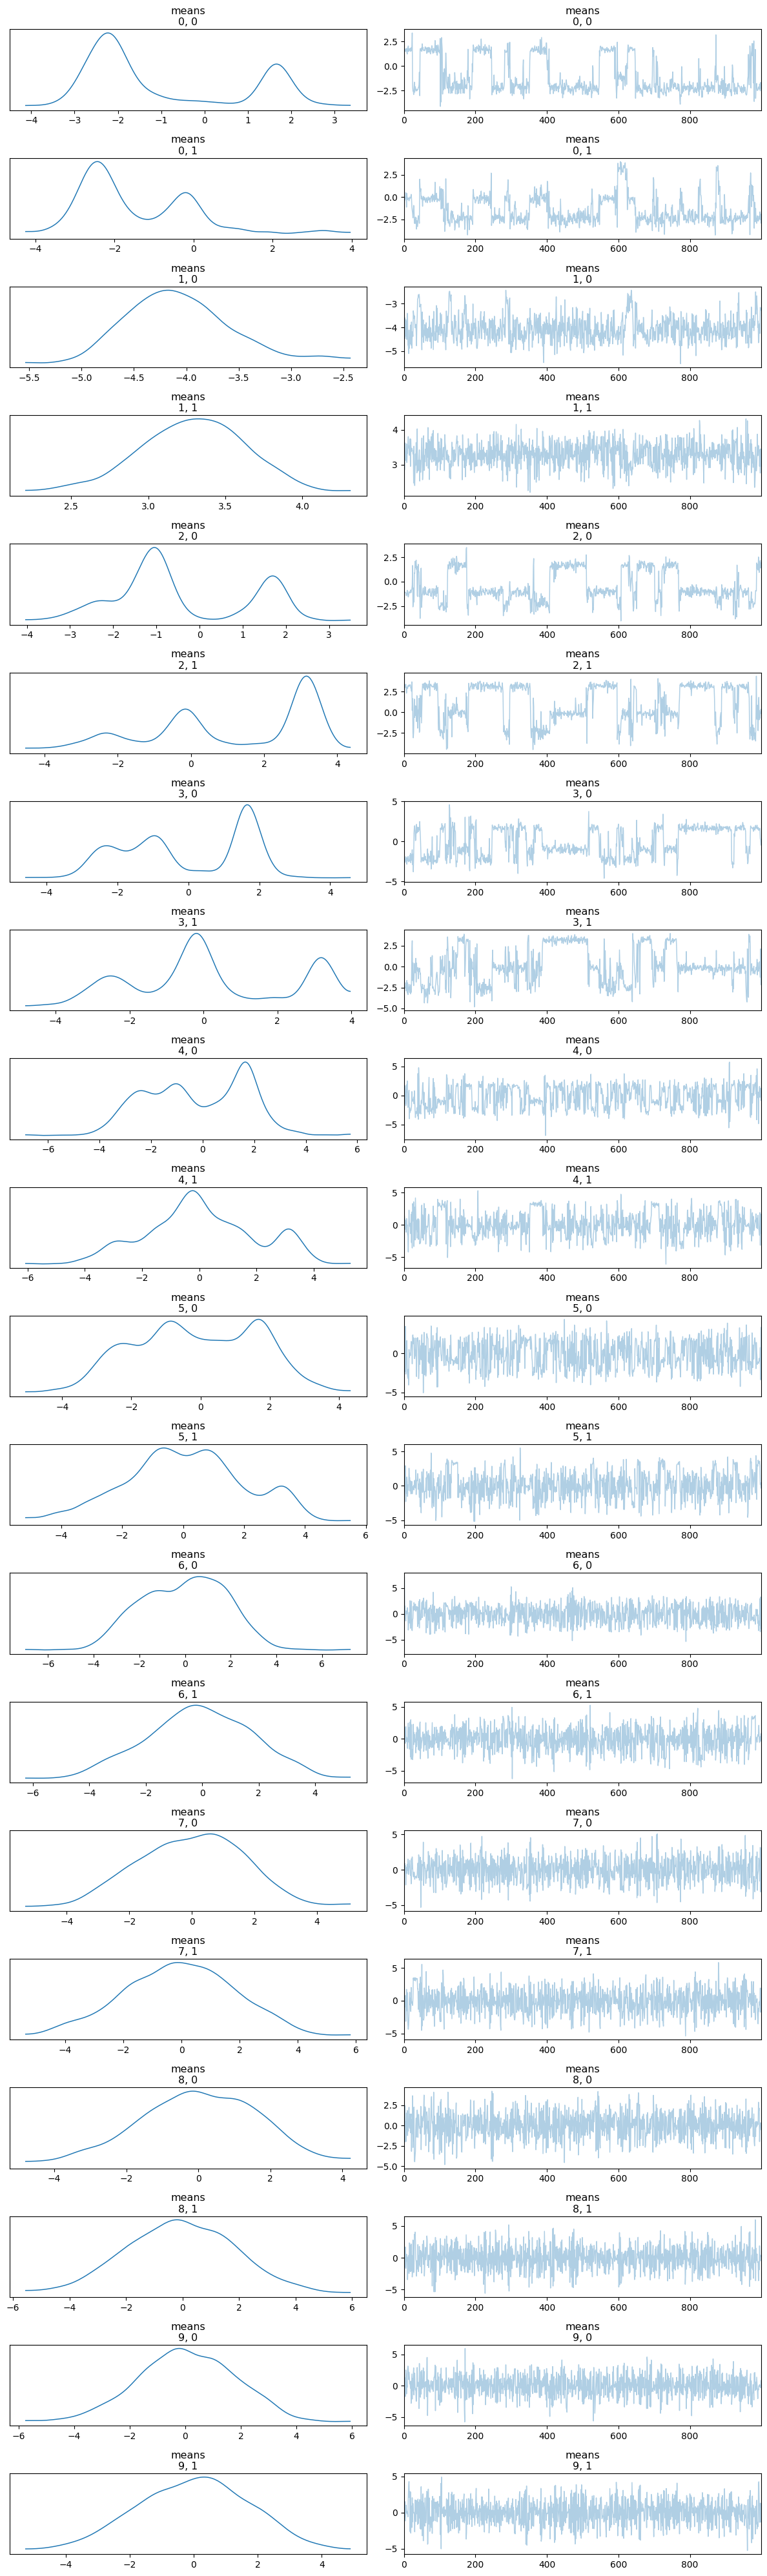

In [ ]:
# Trace plots of the means
az.plot_trace(dp_mix_az, var_names=["means"], compact=False)
plt.tight_layout()
plt.show()

In [ ]:
# Show the clustering (for a fixed iteration)
clus_chain = np.vstack(dp_mix_az.posterior.clus_allocs.values)
clus = clus_chain[-1, :]

# Plot - density histogram + data in clusters + posterior predictive density
plt.hist(datapoints, alpha=0.3, density=True)
for i, cv in enumerate(np.unique(clus)):
    currd = datapoints[clus==cv]
    plt.scatter(currd, np.zeros_like(currd) + 0.005 * (i+1))
plt.plot(dens_grid, np.mean(dp_mix_az.posterior.dens.values[0, :, :], axis=0))

# Show plot
plt.show()

NameError: name 'dp_mix_az' is not defined

In [ ]:
dp_mix_fit.summary()

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.34.1/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmpcctler4t/stansummary-dp_mix-pktxk1_y.csv /tmp/tmpcctler4t/dp_mixyyuu8vwm/dp_mix-20240212180404.csv
cwd: None


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-4.361200e+03,3.455350e-01,6.365650,-4372.230000,-4.361000e+03,-4351.240000,339.392,0.202915,1.004080
"means[1,1]",1.667870e+00,3.674040e-03,0.105696,1.500200,1.666640e+00,1.832680,827.619,0.494816,0.999883
"means[1,2]",-3.057240e-01,3.824950e-03,0.101411,-0.474414,-3.008280e-01,-0.150649,702.944,0.420275,0.999496
"means[2,1]",-4.375150e+00,2.821520e-03,0.085529,-4.513910,-4.378730e+00,-4.222260,918.892,0.549386,1.000300
"means[2,2]",3.787530e+00,1.526230e-03,0.072306,3.672540,3.787270e+00,3.908500,2244.410,1.341890,0.999068
...,...,...,...,...,...,...,...,...,...
dens[9996],6.789610e-07,6.557670e-08,0.000002,0.000000,2.432290e-10,0.000004,908.041,0.542899,1.000840
dens[9997],6.422100e-07,6.251250e-08,0.000002,0.000000,2.002610e-10,0.000004,911.529,0.544984,1.000820
dens[9998],6.070340e-07,5.957550e-08,0.000002,0.000000,1.578440e-10,0.000004,914.767,0.546920,1.000800
dens[9999],5.734050e-07,5.676290e-08,0.000002,0.000000,1.239800e-10,0.000004,917.736,0.548695,1.000780


In [ ]:
means = np.mean(dp_mix_fit.means, axis=0)
print(means)

[[ 1.66786805e+00 -3.05724446e-01]
 [-4.37515216e+00  3.78753487e+00]
 [-1.28992336e+00  3.30475330e+00]
 [-2.84434938e+00 -2.42252187e+00]
 [-1.51941561e+00 -7.33607147e-01]
 [-5.87129827e-01 -1.26759742e+00]
 [-3.02037212e-01 -5.99344781e-01]
 [ 5.94065666e-02 -3.60548758e-01]
 [ 1.08492384e-01 -3.41082750e-01]
 [ 1.09992896e-01 -1.85518764e-01]
 [ 2.86646092e-02 -1.15641917e-01]
 [ 6.95983290e-02 -2.89762771e-02]
 [ 2.44484256e-02 -3.93530459e-02]
 [ 2.79610232e-02  1.03926616e-02]
 [ 9.79694088e-04 -6.98906043e-02]
 [ 4.13298560e-02 -5.30918928e-02]
 [ 7.83190027e-03 -2.48844024e-02]
 [ 1.83701126e-03 -4.59646477e-02]
 [-9.56162263e-03 -3.37670439e-03]
 [-5.23828206e-03 -6.22534199e-02]]


In [ ]:
vars = np.mean(dp_mix_fit.vars, axis=0)
print(vars)

[1.27181183 0.91369662 0.75421935 2.11191561 3.3732074  5.65546596
 3.12631888 2.63470978 2.53211268 2.2307305  2.10915461 2.10614808
 2.19495172 1.79323682 1.98182118 1.8847744  1.93040476 1.98451953
 1.98720426 1.87860317]


In [ ]:
nus = np.mean(dp_mix_fit.nus,axis=0)
print(nus)

[0.24092978 0.29722496 0.54614744 0.4981895  0.45264511 0.51053745
 0.52913494 0.4922211  0.48956057 0.50687468 0.48934588 0.48834406
 0.50030163 0.49019375 0.50452192 0.5001144  0.50368239 0.49262906
 0.51714891]


In [ ]:
phi=-dp_mix_fit.clus_allocs[999,:]
phi=phi/np.linalg.norm(phi)
print(phi)

[[0.00146407 0.00825591 0.00453296 ... 0.00522723 0.00551902 0.00534226]
 [0.00143204 0.01451027 0.00744027 ... 0.00786417 0.00573794 0.00576427]
 [0.00449758 0.00309397 0.00111249 ... 0.00978281 0.00855617 0.00934051]
 ...
 [0.00428249 0.02033832 0.01576811 ... 0.00791502 0.00914688 0.00707731]
 [0.00980754 0.00992693 0.0132574  ... 0.01015519 0.01471563 0.01222529]
 [0.00345707 0.00470079 0.00139162 ... 0.0092476  0.00749254 0.00835915]]


CLUSTER ERROR

Final number of clusters:  20


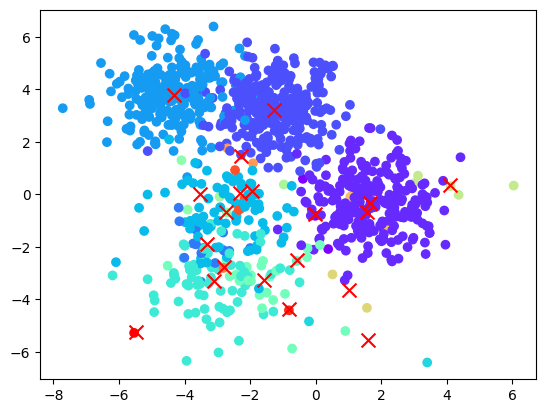

In [ ]:
# Eslicitiamo la likehood di muk rispetto ai dati
# abbiamo vettore assignment, da tradurre come matrice in one-hot-encding

C=np.zeros((n,ntopics))
X=np.array(datapoints)
for i in range(n):
  C[i,assignment[i]]=1
n_cluster = np.sum(C, axis = 0)
m_post=1/(1+1/sigma2**2)/np.matmul(n_cluster.reshape((ntopics,1)),np.ones(shape=(1,d)))*np.matmul(C.T,X)
s2_post=1/(1+1/sigma2**2)/n_cluster

plt.scatter(xs, ys, color=cs)
print('Final number of clusters: ',len(mus))

for i in range(ntopics):
  plt.scatter(m_post[i,0], m_post[i,1], marker='x', color='red', s=100, label=f'Mean Cluster {i}')

plt.show()

In [ ]:
def error_measure(m_real,s2_real,clus_real,m_pred,s2_pred,clus_pred,ntopics):
  K=ntopics
  N=clus_pred.shape[0]
  weights1=1/K*np.ones((K,))
  weights2=np.mean(clus_pred,axis=1)
  mix1=0
  mix2=0
  inter=0
  d=m_real.shape[1]
  K_pred=len(np.unique(clus_pred))

  clus_pred_num=np.empty((N,))
  for i in np.arange(N):
    clus_pred_num[i]=np.argmax(clus_pred[i,])

  K_pred=len(np.unique(clus_pred_num))

  for i in np.arange(K):
    for j in np.arange(K):
      s2_ij=s2_real[i]+s2_real[j]
      mix1+=weights1[i]*weights1[j]*multivariate_normal.pdf(m_real[i,],m_real[j,],s2_ij*np.eye(d))
  for i in np.arange(K_pred-1):
    for j in np.arange(K_pred-1):
      s2_ij=s2_pred[i]+s2_pred[j]
      mix2+=weights2[i]*weights2[j]*multivariate_normal.pdf(m_pred[i,],m_pred[j,],s2_ij*np.eye(d))
  for i in np.arange(K):
    for j in np.arange(K_pred-1):
      s2_ij=s2_real[i]+s2_pred[j]
      inter+=weights1[i]*weights2[j]*multivariate_normal.pdf(m_real[i,],m_pred[j,],s2_ij*np.eye(d))

  error_m_s2=mix1+mix2-2*inter
  clus_real_num=np.empty((N,))
  for i in np.arange(N):
    clus_real_num[i]=np.argmax(clus_real[i,])

  error_clust=1-adjusted_rand_score(clus_real_num,clus_pred_num)
  diff_clus=K-K_pred
  return error_m_s2,error_clust,diff_clus

In [ ]:
m=means
s2=vars

error_m_s2,error_clust,diff=error_measure(m_post,s2_post,C,m,s2,phi,ntopics)
error_m_s2,error_clust,diff

(0.20961019431956637, 0.702642917456418, 15)